<h1 style="font-size:40px;"><center>Exercise I:<br> Training of simple MLP models
</center></h1>


# Short summary
In this exercise you will: 

* train MLPs for simple classification and regression problems.
* learn how hyper-parameters such as learning rate, batch size and number of epochs affect training.

You should write the report of the exercise within this notebook. The details of how to do that can be found below in section "Writing the report".

**Deadline for submitting the report: See Canvas assignment.**

## The data
We will use two synthetic different data sets in this exercise

### syn2
The *syn2* dataset represents a binary classification problem. The input data is 2D which allows for an easy visual inspection of the different classes and the decision boundary implemented by the network. The dataset is generated using random numbers each time you run the cell. This means that each time you generate the data it will be slightly different. You can control this by having a fixed *seed* to the random number generator. The cell "PlotData" will plot the *syn2* dataset.

### regr1
The *regr1* dataset represents a regression problem. It has one input and one target variable. It a cosinus function, with the possibility to add some noise and dampening on the output. Again see the cell "PlotData" to look at the dataset.

## The exercises
There are 8 questions in this exercise. These 8 questions can be found in three different cells below (see section "The Different Cells"). The first 6 questions will use the *regr1* dataset and questions 7-8 will use *syn2*.

## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | MLP | Needed | Defines the MLP model |
| 3 | Data | Needed | Defines the functions to generate the artificial datasets |
| 4 | PlotData | Information | Plots the 2D classification datasets |
| 5 | Statistics | Needed | Defines the functions that calculates various performance measures |
| 6 | Boundary | Needed | Function that can show 2D classification boundaries | 
| 7 | CustomEpochStatistics | Needed | Function to compute (better) per epoch statistics | 
| 8 | Ex1 | Exercise | For question 1-4 |
| 9 | Ex2 | Exercise | For question 5-6 |
| 10 | Ex3 | Exercise | For question 7-8 |

To start with the exercise you need to run all cells with the celltype "Needed". The very first time we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work your way down the cells. Later, when you have started to work with the notebook it may be easier to use the command "Run All" or "Run all above" found in the "Cell" dropdown menu.

## Writing the report
The report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction about the content and purpose of the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.

It is important that you write the report in this last cell and **not** after each question! 

## Last but not least
Have fun!

---

### CellName: Init (#1)
### CellType: Needed
### Cell instruction: Initializing the libraries

In the cell below, we will import needed libraries. 

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, regularizers, optimizers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import scipy as sp
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, log_loss, classification_report
import pandas as pd

### CellName: MLP (#2)
### CellType: Needed
### Cell instruction: Defining the MLP model

This cell defines the MLP model. There are a number of parameters that is needed to 
define a model. Here is a list of them: **Note:** They can all be specified when you call
this function in later cells. The ones specified in this cell are the default values.

* inp_dim: the input dimension (integer)

* n_nod: size of the network, eg [5] for a one hidden layer with 5 nodes and [5,3] for a two layer network with 5 and 3 hidden nodes each.

* act_fun: the activation function. Most common are
    * 'relu'
    * 'tanh'
        
* out_act_fun: the activation function for the output nodes. Most common are
    * 'linear'
    * 'sigmoid'
    * 'softmax'
    
* opt_method: The error minimization method. Common choices
    * 'SGD'
    * 'Adam'
    
* cost_fun: The error function used during training. There are three common ones
    * 'mean_squared_error'
    * 'binary_crossentropy'
    * 'categorical_crossentropy'

* lr_rate: The learning rate.

* metric: The metric to use besides the loss. Common values
    * accuracy
    * mse

Run the cell by entering into the cell and press "CTRL Enter".

In [3]:
def mlp(inp_dim,
            n_nod,
            act_fun = 'tanh',
            out_act_fun = 'linear',
            opt_method = 'SGD',
            cost_fun = 'mse',
            lr_rate = 0.01,
            metric = 'mse',
            num_out = None):
    
    lays = [inp_dim] + n_nod
    
    main_input = Input(shape=(inp_dim,), dtype='float32', name='main_input')
    
    X = main_input
    for i, nod in enumerate(n_nod):
        X = Dense(nod, 
                  activation = act_fun)(X)
        
    output = Dense(1, activation = out_act_fun )(X)
    
    method = getattr(optimizers, opt_method)
    
    model =  Model(inputs=[main_input], outputs=[output])
    model.compile(optimizer = method(learning_rate = lr_rate),
                  loss = cost_fun,
                  metrics=[metric])       

    return model



### CellName: Data (#3)
### CellType: Needed
### Cell instruction: Defining synthetic data sets

This cell defines the two synthetic datasets. The last function is used for standardization of the data. 

Run the cell by entering into the cell and press "CTRL Enter".

In [4]:
def syn2(N):
    
    global seed
     
    x = np.empty(shape=(N,2), dtype = np.float32)  
    d = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)

    # Positive samples
    x[:N1,:] = 0.8 + np.random.normal(loc=.0, scale=1., size=(N1,2))

    # Negative samples 
    x[N1:,:] = -.8 + np.random.normal(loc=.0, scale=1., size=(N-N1,2))
    
    # Target
    d[:N1] = np.ones(shape=(N1,))
    d[N1:] = np.zeros(shape=(N-N1,))

    return x,d


def regr1(N, len = 2, damp=0, v=0):

    global seed

    dx = 2*len*np.pi /(N-1)
    x = np.empty(N, dtype = np.float32) 
    for i in range(N):
        x[i] = i*dx
    
    noise =  lambda  n : np.random.normal(0,1,n)
    if damp == 1:
        d = np.cos(x)*np.exp(-x*0.05)
    else:
        d = np.cos(x)
    
    std_signal = np.std(d)
    d = d + v * std_signal * noise(N)
        
    return x, d


def standard(x):
    return np.mean(x, axis=0) , np.std(x, axis=0)
    

### CellName: PlotData (#4)
### CellType: Information
### Cell instruction: Plotting the data

Here we just generate 100 cases for *syn2* and the *regr1* dataset and plot them. 

Run the cell by entering into the cell and press "CTRL Enter". 

**Note!** This cell is not needed for the actual exercises, it is just to visualize the two datasets.

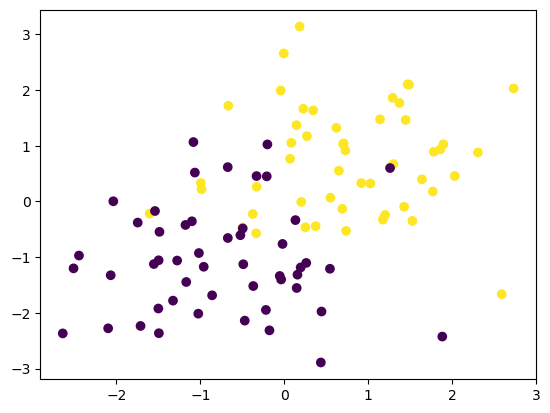

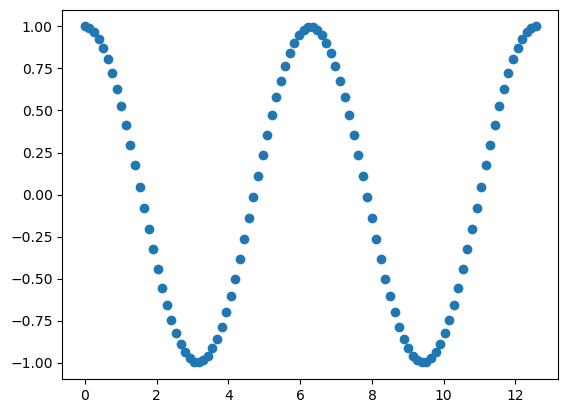

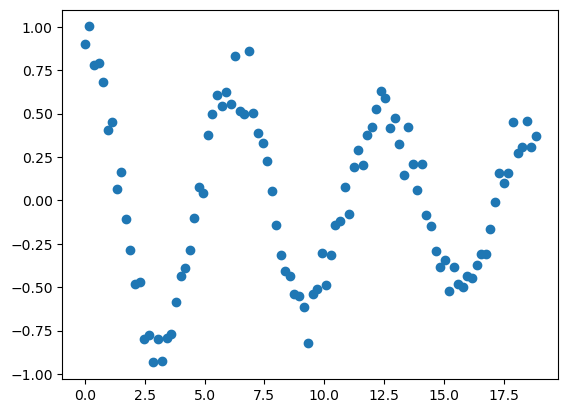

In [5]:
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

x,d = syn2(100)
plt.figure(1)
plt.scatter(x[:,0],x[:,1], c=d)

# Regression, one period, no noise
x,d = regr1(100, 2, 0, 0)
plt.figure(2)
plt.scatter(x,d)

# Regression, 1.5 period, exponential damping, some noise
x,d = regr1(100, 3, 1, 0.2)
plt.figure(3)
plt.scatter(x,d)


### CellName: Statistics (#5)
### CellType: Needed
### Cell instruction: Present result for both classification and regression problems

This cell defines two functions that we are going to call using a trained model to calculate both error and performance measures. 

Run the cell by entering into the cell and press "CTRL Enter".

In [6]:
def stats_class(x = None, d = None, label='training', model = None):
    """
    input :  
             x = input
             d = target
             label = "Provided text string"
             model = the model
             
    output : 
             accuracy = fraction of correctly classified cases
             loss = typically the cross-entropy error
    """
    
    def binary(y1):
        y1[y1>.5] = 1.
        y1[y1<= .5] = 0.        
        return y1

    d_pr = model.predict(x, batch_size = x.shape[0], verbose=0).reshape(d.shape)
                
    nof_p, tp, nof_n, tn = [np.count_nonzero(k) for k in [d==1, d_pr[d==1.] > 0.5, d==0, d_pr[d==0.]<= 0.5]]
    
    acc = (tp + tn) / (len(d))
    loss = model.evaluate(x, d , batch_size =  x.shape[0], verbose=0)
                
    A = ['Accuracy', 'Loss']
    B = [acc, loss[0]]
    
    print('\n','#'*10,'STATISTICS for {} data'.format(label), '#'*10, '\n')
    for i in range(len(A)):
        print('{:15} {:.4f}'.format(A[i], B[i]))

    return print('\n','#'*50)

def stats_reg(x = None, d = None, label='training', model = None):
    """
    input :  
             x = input
             d = target
             label = "Provided text string"
             model = the model
             
    output : 
             mse = mean squared error between target and predictions
             loss = typically mse for regression problems
    """
    
    loss = model.evaluate(x, d, batch_size = x.shape[0], verbose=0)
    d_pr = model.predict(x, batch_size = x.shape[0], verbose=0).reshape(d.shape)
    mse = np.mean((d - d_pr)**2)
    
    A = ['MSE','Loss']
    B = [mse, loss[0]]
    
    print('\n','#'*10,'STATISTICS for {} data'.format(label), '#'*10, '\n')
    for i in range(len(A)):
        print('{:15} {:.10f}'.format(A[i], B[i]))

    return print('\n','#'*50)


### CellName: Boundary (#6)
### CellType: Needed
### Cell Instruction: Decision boundary

This cell defines the function to plot the decision boundary for a 2D input binary MLP classifier. In short, this function defines a grid covering the input data. Each grid point is then used as an input to the trained MLP and to compute an output. If the output is close to 0.5 it is marked as the boundary. 

Run the cell by entering into the cell and press "CTRL Enter".

In [7]:
def decision_b(X, Y1, model ):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # grid stepsize
    h = 0.025

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    
    Z[Z>.5] = 1
    Z[Z<= .5] = 0

    Y_pr = model.predict(X, batch_size = X.shape[0], verbose=0).reshape(Y1.shape)
  
    Y = np.copy(Y1)
    Y_pr[Y_pr>.5] = 1
    Y_pr[Y_pr<= .5] = 0
    Y[(Y!=Y_pr) & (Y==0)] = 2
    Y[(Y!=Y_pr) & (Y==1)] = 3
    
    
    plt.figure()
    #plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha = .9) 
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    
    
    plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], marker='+', c='k')
    plt.scatter(X[:, 0][Y==0], X[:, 1][Y==0], marker='o', c='k')
       
    plt.scatter(X[:, 0][Y==3], X[:, 1][Y==3], marker = '+', c='r')   
    plt.scatter(X[:, 0][Y==2], X[:, 1][Y==2], marker = 'o', c='r')
    
    
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.show()


### CellName: CustomEpochStatistics (#7)
### CellType: Needed
### Cell Instruction: Compute alternative epoch statistics

This cell defines a callback function to be executed after each completed epoch. The purpose is to be able to monitor the "real" loss after each epoch and not the one reported by Keras that is based on the last batch of the epoch.

Run the cell by entering into the cell and press "CTRL Enter".

In [8]:
class EpochCallback(Callback):
    
    def __init__(self, x_trn, y_trn):
        self.x_trn = x_trn
        self.y_trn = y_trn
           
    def on_epoch_end(self, epoch, logs=None):
        x_trn, y_trn = self.x_trn, self.y_trn
        perf = self.model.evaluate(x_trn, y_trn, verbose=0, batch_size = x_trn.shape[0])
        id1 = 'epoch_' + self.model.metrics_names[0]
        logs[id1] = perf[0]
        id2 = 'epoch_' + self.model.metrics_names[1]
        logs[id2] = perf[1]
        #print("Epoch {} (end): loss = {:.4f}  epoch_loss = {:.4f}\n".format(epoch+1, logs["loss"], logs["epoch_loss"]))
                

---
End of "Needed" and "Information" cells. Below are the cells for the actual exercise.

---

### CellName: Ex1 (#8)
### CellType: Exercise
### Cell instruction: Instruction for questions 1-4
Questions 1-4 look at three essential parameters that controls the training process of an MLP: the *learning rate*, *batch size* and *number of epochs* (or epochs for short). By training process we mean here the minimization of the given loss function. The task is to train an MLP with four hidden nodes that can fit the *regr1* dataset. In this version of the dataset, there is no noise. Therefore, we need not specify any seed.

The dataset and network have been selected so that it is possible, but not trivial, to get a good training result.
A successful training means here when the networks has reached a loss < 0.01, and visually have fitted the data accurately. In this exercise we do not care about possible overfitting, only about the minimization of the loss function, we therefore do not have a validation dataset.

#### Question 1, variations in pre-defined MLP
For the first question you can simply run the cell below. It will load 50 samples from the *regr1* dataset (no noise added). The network has 4 hidden nodes in a single hidden layer, *tanh* activation function, linear output activation function, *stochastic gradient descent* as minimization method, MSE loss function, and a learning rate of 0.05.
It will train for 4000 epochs using a batchsize of 50, meaning that we efficiently are using ordinary gradient descent learning. Run this cell five times. **(a) Do you see the same loss vs epoch behavior each time your run?** If not, **why?** **(b) Do you observe that training fails, i.e. do not reach low loss, during any of these five runs?** 

#### Question 2, vary learning rate
You will now study what happens when you train with different learning rates. Test at least 5 different learning rates in the range from 0.001 to 0.5. For each learning rate train the network three times and record the average MSE value over these three runs. **Present your average MSE results and discuss your findings**.

**Note:** You should keep the same settings as for Q1, only vary the learning rate. The learning rate is best investigated with (roughly) proportional changes rather than constant steps: For example, trying 0.5, 0.2, 0.1, 0.05, 0.02 etc. typically gives more interesting results than 0.5, 0.4, 0.3, 0.2, 0.1.

#### Question 3, vary (mini)batch size
We now (hopefully) have discovered that the learning rate influences the efficiency of the loss minimization. We will now look at what happens when we use *stochastic gradient descent*, meaning that we will have a "batch size" that is smaller the the size of the training data. (We now adapt to Keras language, and use the word "batch" where most litterature would use "mini-batch".) Use a fixed learning rate of 0.05, but test different batch sizes in the range 1 to 50. Train three different networks for each batch size, but this time record if the training was successful (i.e. MSE < 0.01) and approximately after how many epochs the good solution was found. **Present and discuss your findings**.

**Note:** The batch size should (fairly well) divide the total data size. With a data size of 50, good batch sizes are 50, 25, 13, 10, 8, 7... Sizes that fit poorly, like 40, create a 'rest'-batch that must be handled by the Keras package somehow, and you need to carefully study Keras documentation to understand what it does.

#### Question 4, select good hyper-parameters
Find a combination of learning rate and batch size that gives a good solution within 1000 epochs. We always have to remember that two runs with identical hyper parameters (e.g. learning rate, batch size etc) will result in different final results. Your set of parameters should *most* of the times result in a good solution within 1000 epochs. **Present your best combination of learning rate and batch size, and its result**.

#### Remark: What is acually plotted by Keras?
In all of Loss/MSE per Epoch plots you have looked at so far, the values plotted are coming from "internal" Keras calculations. It turns out that loss and MSE values are not really calculated as true per epoch values. To speed up calculations Keras reports the loss/MSE for the last mini-batch (in the current epoch) before updating the weights. This is not the same as calculating the loss/MSE for the full training dataset at the end of the epoch. This is good to know! To illustrate this we have added what is called a CallBack function that actually computes the true loss/MSE per epoch.

Add the additional argument to the fit statement:

`callbacks=[EpochCallback(x_trn, d_trn)]`

The modified statement should now look like this:

~~~
estimator_ex1 = model_ex1.fit(x_trn, d_trn,
                              epochs = number_epochs,      
                              batch_size = minibatch_size,
                              verbose = 0, 
                              callbacks=[EpochCallback(x_trn, d_trn)])
~~~

To see the difference between what Keras produces and our own calculations of the loss/MSE per epoch use following setup:

Epochs = 200, Mini-batch size = 10, Learning Rate = 0.05

You should see that the curves denoted "epoch_loss/epoch_mse" are smoother compared to the curves denoted "loss/mse" that are computed by Keras. The differences between the two ways of computing the loss/mse should decrease if we make smaller updates, i.e. using a smaller learning rate, as illustrated by the follwoing setup:

Epochs = 200, Mini-batch size = 10, Learning Rate = 0.01

Using the CallBack functionallity to compute the "true" loss/mse per epoch is slower since we need to make a complete forward pass for the full training dataset at each epoch. However sometimes this is needed to find optimal minimization parameters. For the rest of the exercise we will *not* use the CallBack, to speed up the training process.  


Model: "model_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_250 (Dense)           (None, 4)                 8         
                                                                 
 dense_251 (Dense)           (None, 1)                 5         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


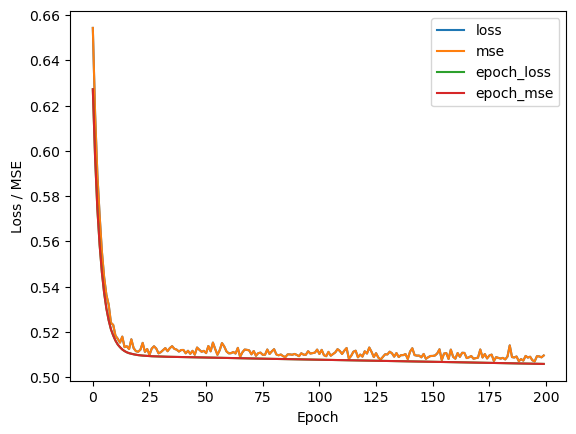


 ########## STATISTICS for Training data ########## 

MSE             0.5059040034
Loss            0.5059040189

 ##################################################


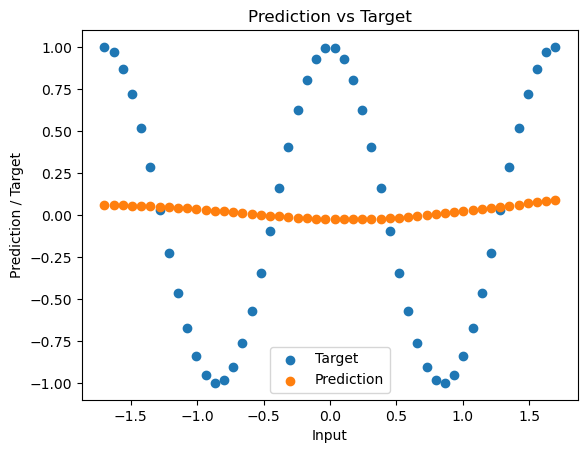

CPU times: total: 3.62 s
Wall time: 17.2 s


In [141]:
%%time
#### not used for Q1-Q4
# seed = 0 means random, seed > 0 means fixed
# seed = 0
# np.random.seed(seed) if seed else None
####

# Generate training data
x_trn, d_trn = regr1(50, 2, 0, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

#### 
# Define the network, cost function and training settings
INPUT1 = {'inp_dim': 1,         
         'n_nod': [4],                   # number of nodes in hidden layer
         'act_fun': 'tanh',              # activation functions for the hidden layer
         'out_act_fun': 'linear',        # output activation function
         'opt_method': 'SGD',            # minimization method
         'cost_fun': 'mse',              # error function
         'lr_rate': 0.01                 # learning rate
        }    
number_epochs = 200
minibatch_size = 10
####    

# Get the model
model_ex1 = mlp(**INPUT1)

# Print a summary of the model
model_ex1.summary()

# Train the model
estimator_ex1 = model_ex1.fit(x_trn, d_trn,
                              epochs = number_epochs,      
                              batch_size = minibatch_size,
                              verbose = 0, 
                              callbacks=[EpochCallback(x_trn, d_trn)])


# Training history
plt.figure()
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
for k in estimator_ex1.history.keys():
    plt.plot(estimator_ex1.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Call the stat_reg to get MSE
#pred_trn = model_ex1.predict(x_trn, verbose=0).reshape(d_trn.shape)
stats_reg(x_trn, d_trn, 'Training', model_ex1)

# Plot the result
d_pred = model_ex1.predict(x_trn, verbose=0)
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()



### CellName: Ex2 (#9)
### CellType: Exercise
### Cell instruction: Instruction for questions 5-6
The amount of weights in the network can also influence how long time we need to train, and of course if the problem itself is complex or not. The following two questions will highlight this.

#### Question 5, vary epochs
The example below will load a slightly more complex *regr1* problem (an additional quarter of a period). We will use 10 hidden nodes for this problem. Use your optimal set of learning rate and batch size as found in Q4 and train the network below. **Compare the number of epochs needed to reach a good solution with that of Q4**. Note, you may need to vary the number of epochs a lot! If you cannot find a good solution in a reasonable number of epochs, you can "revert" the problem: optimize learning rate and batch size for Q5, and the see how those hyper-parameters perform on Q4.

#### Question 6, vary network size and other hyper-parameters
Use the following line to load the *regr1* data set:

`x_trn, d_trn = regr1(75, 5, 1, 0.0)`

This will create an even more challenging regression task that may need an even larger network. Your task is to find a set of hyper-parameters (learning rate, batch size, epochs, 'size of the network') that result in a good solution. You can use more than one hidden layer for this task (if you want). To create many hidden layers, add many numbers to the n_nod list, for example: `'n_nod': [10,5,5]`. **Present your set of good hyper-parameters and the result**. 

**Note:** If you cannot solve this task in *reasonable* time, present your best attempt!


Model: "model_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_276 (Dense)           (None, 16)                32        
                                                                 
 dense_277 (Dense)           (None, 12)                204       
                                                                 
 dense_278 (Dense)           (None, 1)                 13        
                                                                 
Total params: 249 (996.00 Byte)
Trainable params: 249 (996.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


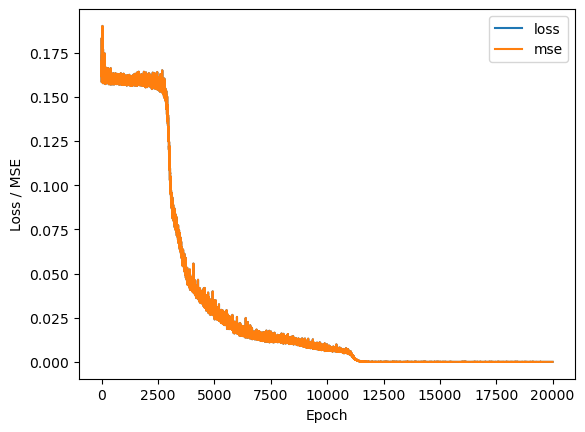


 ########## STATISTICS for training data ########## 

MSE             0.0001352573
Loss            0.0001352574

 ##################################################


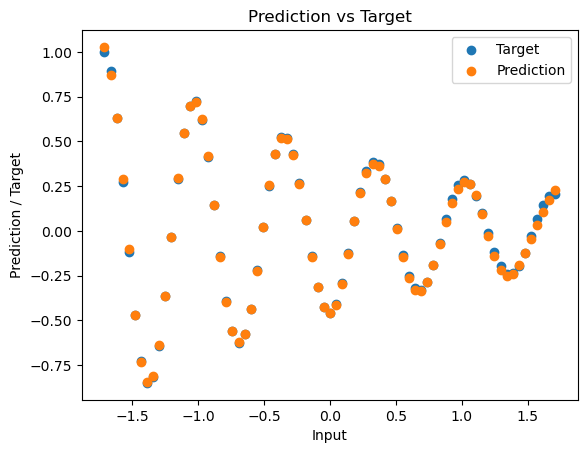

CPU times: total: 1min 6s
Wall time: 6min 24s


In [150]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

# Generate training data
# For Q5:
# x_trn, d_trn = regr1(50, 2.5, 0, 0.0)

# For Q6:
x_trn, d_trn = regr1(75, 5, 1, 0.0)

# Standardization of inputs
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

#### 
# Define the network, cost function and training settings
INPUT2 = {'inp_dim': 1,         
         'n_nod': [16, 12],           # number of nodes in hidden layer
         'act_fun': 'tanh',              # activation functions for the hidden layer
         'out_act_fun': 'linear',        # output activation function
         'opt_method': 'SGD',            # minimization method
         'cost_fun': 'mse',              # error function
         'lr_rate': 0.05                 # learning rate
        }        
number_epochs = 20000
minibatch_size = 10
####

# Get the model
model_ex2 = mlp(**INPUT2)

# Print a summary of the model
model_ex2.summary()

# Train the model
estimator_ex2 = model_ex2.fit(x_trn, d_trn,
                              epochs = number_epochs,      
                              batch_size = minibatch_size,
                              shuffle=True,
                              verbose = 0)


# Training history
plt.figure()
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
for k in estimator_ex2.history.keys():
    plt.plot(estimator_ex2.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Call the stat_reg to get MSE and correlation coefficiant for the scatter plot
stats_reg(x_trn, d_trn, 'training', model_ex2)

# Plot the result
d_pred = model_ex2.predict(x_trn, verbose=0).reshape(d_trn.shape)
plt.figure()
plt.ylabel('Prediction / Target')
plt.xlabel('Input')
plt.scatter(x_trn, d_trn, label='Target')
plt.scatter(x_trn, d_pred, label='Prediction')
plt.title('Prediction vs Target')
plt.legend(loc='best')
plt.show()


### CellName: Ex3 (#10)
### CellType: Exercise
### Cell instruction: Instructions for questions 7-8
We will now look at the classification problem defined by the *syn1* dataset.
The cell below defines a single hidden node MLP. With this network you can only implement a linear decision boundary. Run the cell below to look at the resulting boundary that the MLP learns. The training accuracy is around 87-93%, because the data is generated randomly each time you run the code. 

#### Question 7, optimize hyper-parameters for classification
Your task is now to reach a larger accuracy by fitting a model with more hidden nodes (and possibly more hidden layers). 
Your aim is to reach a training accuracy > 95%. To do that you need to tune the learning rate, batch size, epochs and the size of your MLP. **Present your set of hyper parameters that reach > 95% accuracy**

**Note**: To always generate exactly the same dataset each time you run the code you can set the *seed* to a value > 0. 

#### Question 8, change learning algorithm
We have so far only used stochastic gradient descent (SGD), but we know that there exists modifications of SGD that are very popular, e.g. Adam. 
**Try the Adam optimizer for Q7, and compare (qualitatively) the results and the number of epochs needed to get them.**

The interpretation of the learning rate differs a bit between SGD and Adam. Since your learning rate was optimized for SGD in Q7, you could consider optimizing it again for Adam, before you compare SGD with Adam. **Present changes you needed to make to improve the results of the Adam optimizer, if any.**


**Info**: Adam has two extra parameters. The way we call the Adam optimizer, they will be kept at their default values *beta1* = 0.9 and *beta2* = 0.999. 

#### Bonus tasks
The bonus tasks are provided if you have extra time and want to continue to explore methods that can further enhance the minimization of the loss function. **These tasks are not required for the course and do not influence any grading**. 

The tasks listed below also mean that you have to change the code in code cell *MLP* (#2). There will be links to appropriate documentation below.

* Go back to Q7 and add use a momentum add-on to SGD. **Does momentum help?** (See documentation [here](https://keras.io/api/optimizers/sgd/))
* It is common to also introduce a mechanism that can lower the learning rate as we train. If we are using stochastic gradient descent the mini-batch gradients will never be zero, meaning that we will always make some small weight updates. Keras have methods that can lower the learning rate as we train (see [here](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/)). Again go back to Q7 and now use an exponential decaying learning rate. **Does it help?**  



Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_24 (Dense)            (None, 12)                36        
                                                                 
 dense_25 (Dense)            (None, 1)                 13        
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



 ########## STATISTICS for Training data ########## 

Accuracy        1.0000
Loss            0.0131

 ##################################################


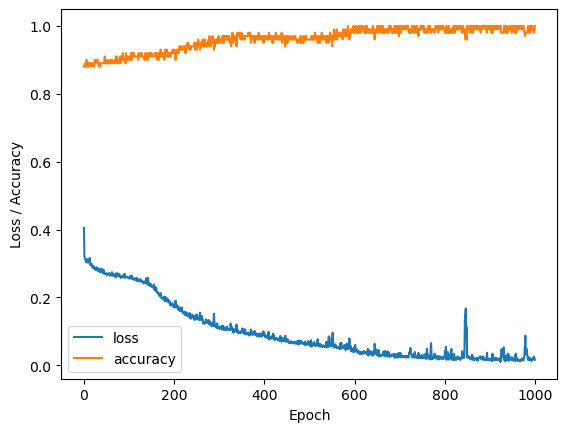

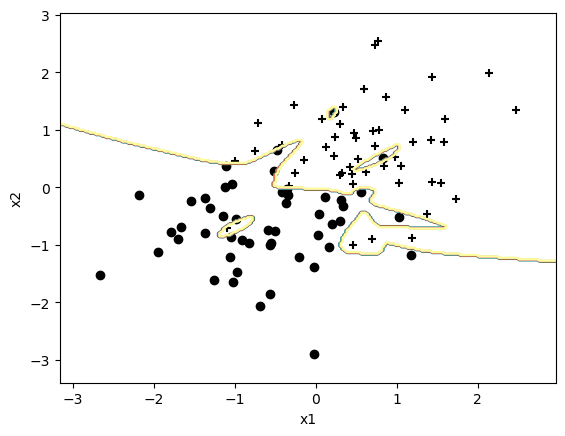

CPU times: total: 5.12 s
Wall time: 27.7 s


In [21]:
%%time

# seed = 0 means random, seed > 0 means fixed
seed = 10
np.random.seed(seed) if seed else None
    
# Generate training data
x_trn, d_trn = syn2(100)

# General standardization of input data 
mu, std = standard(x_trn)
x_trn = (x_trn - mu)/std

#### 
# Define the network, cost function and training settings
INPUT3 = {'inp_dim': x_trn.shape[1],         
         'n_nod': [12],                     # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'sigmoid',          # output activation function
         'opt_method': 'Adam',              # minimization method
         'cost_fun': 'binary_crossentropy', # error function
         'lr_rate': 0.05,                   # learning rate
         'metric': 'accuracy'               # metric for evaluation
        } 
number_epochs = 1000
minibatch_size = 10
####

# Get the model
model_ex3 = mlp(**INPUT3)

# Print a summary of the model
model_ex3.summary()

# Train the model
estimator_ex3= model_ex3.fit(x_trn, d_trn,
                      epochs = number_epochs,                
                      batch_size = minibatch_size,                   
                      verbose = 0)

# Call the stats function to print out statistics for the training
stats_class(x_trn, d_trn, 'Training', model_ex3)

# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
for k in estimator_ex3.history.keys():
    plt.plot(estimator_ex3.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Show the decision boundary
decision_b(x_trn, d_trn, model_ex3)


# The report!

We have added intructions inside this report template. As you write your report, remove the instructions.

## Name
Theodor Anderberg Törngren

## Introduction
In this report, the hyper parameters of neural networks will be examined. The main focus in the report lays on the learning rate, batch-size, number of epochs, and number of nodes in the network. The effect of these will be examined in several different situations.

## Answers to questions
Provide enough information to clarify the meaning of your answers, so that they can be understood by someone who does not scroll up and read the entire instruction.

The questions are repeated here, for clarity of what is demanded. If it does not fit your style to quote them verbatim, change the format. 

#### Question 1, variations in pre-defined MLP
The loss vs epoch graph is different for every time. This is due to the randomized starting values of the weights in the ANN. 

In 2 out of the 5 runs, the training fails. This is due to the stochastic gradient descent not finding the minima in time. This results in the predicted datapoints being completely wrong.

#### Question 2, vary learning rate
The results of the different model with varying learning rates are presented in the following table. 

| Learning Rate | Run 1: MSE | Run 2: MSE | Run 3: MSE | Average MSE |
| :---          | :---       | :------    | :--------  | :-------    |
| 0.5           | NaN | NaN | Nan | Nan |
| 0.1           | 0.0018297489 | 0.0015869502 | 0.0002321941 | 0.00121629773 |
| 0.05          | 0.4476928154 | 0.0054067914 | 0.0026150680 | 0.151904892 |
| 0.01          | 0.4933806419 | 0.4978894475 | 0.4970285418 | 0.496099543 |
| 0.005         | 0.4996215246 | 0.4888905640 | 0.4936040793 | 0.494038723 |
| 0.001         | 0.5029884929 | 0.5084693110 | 0.5082167847 | 0.506558197 |

Changing the learning rate corresponds to taking shorter steps during the minimization algorithm of the weights, i.e. the training. This results in slower training, but with lowered risk of diverging during training or "skipping over" a minima of the loss function. In this case, it seems as if the learning rate of 0.1 has the best results, as it has the lowest average mean squared error (MSE). This indicates that the learning rate of 0.1 probably does not skip over minimas in the loss function during the gradient descent. With the learning rate of 0.5, there was a division of zero during the MSE calculations and a divergence during training, where the loss increased dramatically. This indicates that the learning rate of 0.5 is too high. The interesting region that probably contains the optimal learning rate for this problem is therefore 0.5-0.05.  

#### Question 3, vary (mini)batch size
The varying batch sizes and that were examined, and their corresponding results are presented in the following table: 

| Batch Size | Convergence ratio | Average convergence epoch (if convergence) |
|:---|:----|:-----|
| 50 | 2/3 | 2350 |
| 25 | 3/3 | 2617 |
| 10 | 3/3 | 1167 |
| 5  | 2/3 | 950 |
| 1  | 0/3 | - |

The trend in the results are that smaller batches result in a convergence in less epochs, but if the batch size is chosen too small, this results in the training not converging. This can be observed when the batch size is put to 1. Another effect of modifying the batch size is the time for training each epoch. With smalles batches, one epoch takes longer time, due to the increased amount of calculations in the batch. 

#### Question 4, select good hyper-parameters
The combination of a learning rate of 0.1, and a batch size of 5, results in a model that consistently converges in less than a 1000 epochs, with an average convergence after approximately 500 epochs. The results of three runs of the training algorithm are presented in the following table. 

| Run # | Convergence | Convergence epoch (if convergence) |
|:--|:----|:----|
| 1 | Yes | 600 |
| 2 | Yes | 400 |
| 3 | Yes | 450 |

#### Question 5, vary epochs
In the more complex problem in Q5, the hyper-parameters needed to be changed to ensure consistent convergence and loss minimization. When modifying the learning rate to 0.05 and the batch size to 10, the model consequently converged within 4000 epochs, with an average convergence epoch of 2400.  

| Run # | Convergence | Convergence epoch (if convergence) |
|:--|:----|:-----|
| 1 | Yes | 2000 |
| 2 | Yes | 2600 |
| 3 | Yes | 2600 |

This is significantly more epochs than the ones needed to solve Q4. This is probably due to the increased complexity of the problem, but it could possibly indicate that the other hyper-parameters could be optimized further.

#### Question 6, vary network size and other hyper-parameters 
The following parameters resulted in a model that could consistently solve the even more challending problem presented in Q6, where the sinus curve is dampened. 

| Parameter | Value |
|:----------|:------|
| Learning rate | 0.05 |
| Batch size | 10 |
| Epochs | 20 000 |
| Network architecture | [16,12] |

A prediction from the model with these hyperparameters are displayed in the following picture: 

<image src = "./Question6_Result1.png">

This prediction had a MSE of 0.0001352573. 

The model with these hyperparameters can fit the dampened curve consistently, and the model achieves a near-zero loss within 20 000 epochs. The average convergence happens whithin 15 000 epochs. 

#### Question 7, optimize hyper-parameters for classification
With the follwing hyper-parameters, an accuracy of > 95% was reached consistently in the classification task with the syn1 dataset. 

| Parameter | Value |
|:----------|:------|
| Learning rate | 0.05 |
| Batch size | 10 |
| Epochs | 10 000 |
| Network architecture | [12] |

The large number of epochs and nodes in the network leads to overtraining, and the model will probably not score as well on a validation or test set of different data.  

A resulting decision boundary from the model is presented below.

<image src = "./Question7_Result1.png">

This model achieved an accuracy of 98%, and we can observe some seemingly strange behaviour of the decision boundary, such as closed rings around outliers in the data. This is one key indication that aiming for 95% accuracy can result in overtraining. 

#### Question 8, change learning algorithm
With the same task as in Q7, we now switch to the Adam optimization method, instead of using stochastic gradient descent. This results in the network being able to achieve increased accuracy in only 1 000 epochs instead of 10 000. This indicated that the Adam optimizer is much better suited for this classification task, if one does not worry about overtraining. But if the requirement is to achieve above 95% accuracy, and the succes is measured in number of epochs, the Adam method significantly outperforms SGD in this problem.

## Summary
In the report, we have examined the different hyper-parameters for neural networks, and their effect on the resulting trained model. The number of epochs used in training affect the training time of the network, is one of the major factors affecting under- or overtraining.

The number of nodes in the network affect the network's ability to handle complex problems, and a larger network increases the time requirements in training the network. 

The learning rate determines how large steps are taken during training. A too small learning rate results in slow training, and a too large results in inprecice training that does not converge. 

The main optimization method used in the lab is Stochastic Gradient Descent, where the training data is grouped in small batches, and these are used to calculate the gradient descent steps. The batch size controls the size of these batches, and a large batch size results in an algorithm similar to the classic gradient descent. A smaller batch size results in a minimization algorithm that takes many small steps, based on small parts of the data, only a few samples. The optimal batch size can result in escaping local mimimi and plateus, due to them being related to certain weights, that are not necessarily used when calculating the next gradient descent direction.